# 使用决策树进行个人信用风险评估


2007-2008年的全球金融危机凸显了透明度和严密性在银行业务中的重要性。由于信贷供应收到了限制，所以银行正日益紧缩其贷款体系，转向机器学习来更准确地识别高风险贷款。

决策树模型准确性高且可解释性好，所以被广泛地应用在银行业。在很多国家，政府机构会密切监控贷款业务，所以银行需要明确地解释为什么一个申请者的贷款申请被拒绝或者批准。这种可解释性对于贷款申请者也是很重要的，申请者需要知道为什么自己的信用级别不符合银行的要求。

通过构建自动化的信用评分模型，以在线方式进行即时的信贷审批能够为银行节约很多人工成本。
本案例，我们将使用C5.0决策树建立一个简单的个人信用风险评估模型。

## 1 数据源
使用UCI上的德国信用数据集。该数据集包含了1000个贷款信息，每一个贷款有20个自变量和一个类变量记录该笔贷款是否违约。
我们将使用该数据集构建模型来预测贷款是否违约。

## 2 数据探索和预处理
首先，使用pandas的read_csv()函数读入数据。

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

credit = pd.read_csv('./credit.csv')
credit.head(5)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,job,dependents,telephone,foreign_worker,default
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,skilled employee,1,yes,yes,1
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,skilled employee,1,none,yes,2
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,1
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,skilled employee,2,none,yes,1
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,skilled employee,2,none,yes,2


可以看到,该数数据集包含 1000 个样本和 21 个变量, 变量类型同时包括因子变量和数值变量,　使用 value_counts() 函数对支票余额变量 check_balance 和储蓄账号余额变量 saveings_balance 进行查看.

In [43]:
credit.checking_balance.value_counts()

unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64

In [44]:
credit.savings_balance.value_counts()

< 100 DM         603
unknown          183
101 - 500 DM     103
501 - 1000 DM     63
> 1000 DM         48
Name: savings_balance, dtype: int64

上述两个变量的单位都是德国马克(DM),　直观的来看, 支票余额和储蓄账户余额越大, 贷款违约的可能性越小.

该贷款数据集还有一些数值型变量, 例如贷款期限(months_long_duration) 和贷款额度(amount)。

In [45]:
credit[['months_loan_duration', 'amount']].describe()

,months_loan_duration,amount
count,1000.000000,1000.000000
mean,20.903000,3271.258000
std,12.058814,2822.736876
min,4.000000,250.000000
25%,12.000000,1365.500000
50%,18.000000,2319.500000
75%,24.000000,3972.250000
max,72.000000,18424.000000


In [46]:
credit[['months_loan_duration', 'amount']].median()

months_loan_duration      18.0
amount                  2319.5
dtype: float64

可见贷款期限为 4-72 个月, 中位数字 18个月,　贷款申请额度在 250-18420马克之间,　中位数字 2319.5马克.

变量 default 表示贷款是否违约,　也是我们需要预测的目标, 在 10000 个贷款中, 30% 贷款申请者有违约行为.

In [47]:
credit.default.value_counts()

1    700
2    300
Name: default, dtype: int64

银行不希望违约用户违约率高,　因为这些客户会给银行带来损失, 如果建模的目标是识别可能违约的用户, 从未减少违约的数量.

### ３ 划分训练集和测试集

在正式建模之前, 我们需要将数据集分为训练集和测试集, 其中训练集用来构建决策模型, 测试集用来评估模型的性能, 我们将 70% 数据作为 训练集数据, 30% 作为测试集数据, 在化分数据之前,　我们需要讲数据中字符串形式的变量使用整数进行编码

In [48]:
col_dicts = {}
cols = ['checking_balance','credit_history', 'purpose', 'savings_balance', 'employment_length', 'personal_status', 
        'other_debtors','property','installment_plan','housing','job','telephone','foreign_worker']

col_dicts = {'checking_balance': {'1 - 200 DM': 2,
  '< 0 DM': 1,
  '> 200 DM': 3,
  'unknown': 0},
 'credit_history': {'critical': 0,
  'delayed': 2,
  'fully repaid': 3,
  'fully repaid this bank': 4,
  'repaid': 1},
 'employment_length': {'0 - 1 yrs': 1,
  '1 - 4 yrs': 2,
  '4 - 7 yrs': 3,
  '> 7 yrs': 4,
  'unemployed': 0},
 'foreign_worker': {'no': 1, 'yes': 0},
 'housing': {'for free': 1, 'own': 0, 'rent': 2},
 'installment_plan': {'bank': 1, 'none': 0, 'stores': 2},
 'job': {'mangement self-employed': 3,
  'skilled employee': 2,
  'unemployed non-resident': 0,
  'unskilled resident': 1},
 'other_debtors': {'co-applicant': 2, 'guarantor': 1, 'none': 0},
 'personal_status': {'divorced male': 2,
  'female': 1,
  'married male': 3,
  'single male': 0},
 'property': {'building society savings': 1,
  'other': 3,
  'real estate': 0,
  'unknown/none': 2},
 'purpose': {'business': 5,
  'car (new)': 3,
  'car (used)': 4,
  'domestic appliances': 6,
  'education': 1,
  'furniture': 2,
  'others': 8,
  'radio/tv': 0,
  'repairs': 7,
  'retraining': 9},
 'savings_balance': {'101 - 500 DM': 2,
  '501 - 1000 DM': 3,
  '< 100 DM': 1,
  '> 1000 DM': 4,
  'unknown': 0},
 'telephone': {'none': 1, 'yes': 0}}

for col in cols:
    credit[col] = credit[col].map(col_dicts[col])
credit.head(5)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,job,dependents,telephone,foreign_worker,default
0,1,6,0,0,1169,0,4,4,0,0,...,0,67,0,0,2,2,1,0,0,1
1,2,48,1,0,5951,1,2,2,1,0,...,0,22,0,0,1,2,1,1,0,2
2,0,12,0,1,2096,1,3,2,0,0,...,0,49,0,0,1,1,2,1,0,1
3,1,42,1,2,7882,1,3,2,0,1,...,1,45,0,1,1,2,2,1,0,1
4,1,24,2,3,4870,1,2,3,0,0,...,2,53,0,1,2,2,2,1,0,2


现在, 我们从数据集中随机的选取其中的 70% 作为训练数据, 30% 作为测试数据,



In [51]:
from sklearn import model_selection

y = credit['default']

X = credit.loc[:,'checking_balance':'foreign_worker']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3,random_state=0)

我验证以下训练集和测试集中, 违约贷款的比例是否接近

In [52]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

1    0.694286
2    0.305714
Name: default, dtype: float64
1    0.713333
2    0.286667
Name: default, dtype: float64


可见训练集和测试集中违约贷款比例接近 30%

### 模型训练

我们将使用 Skikit-learn 中的 DecisionTreeClassifier 算法来训决策树模型, DecisionTreeClassifier 算法位于 sklearn.tree　包, 首先将其导入,　然后调用 fit 方法进行模型训练.

In [55]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
credit_model = DecisionTreeClassifier(min_samples_leaf=6)
credit_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

现在,　credit_model 就是我们训练得到的决策树模型, 可以通过可是化将其展现出来.

**注: 绘制决策树模型的图形时,　请注意 python 的版本是个坑**

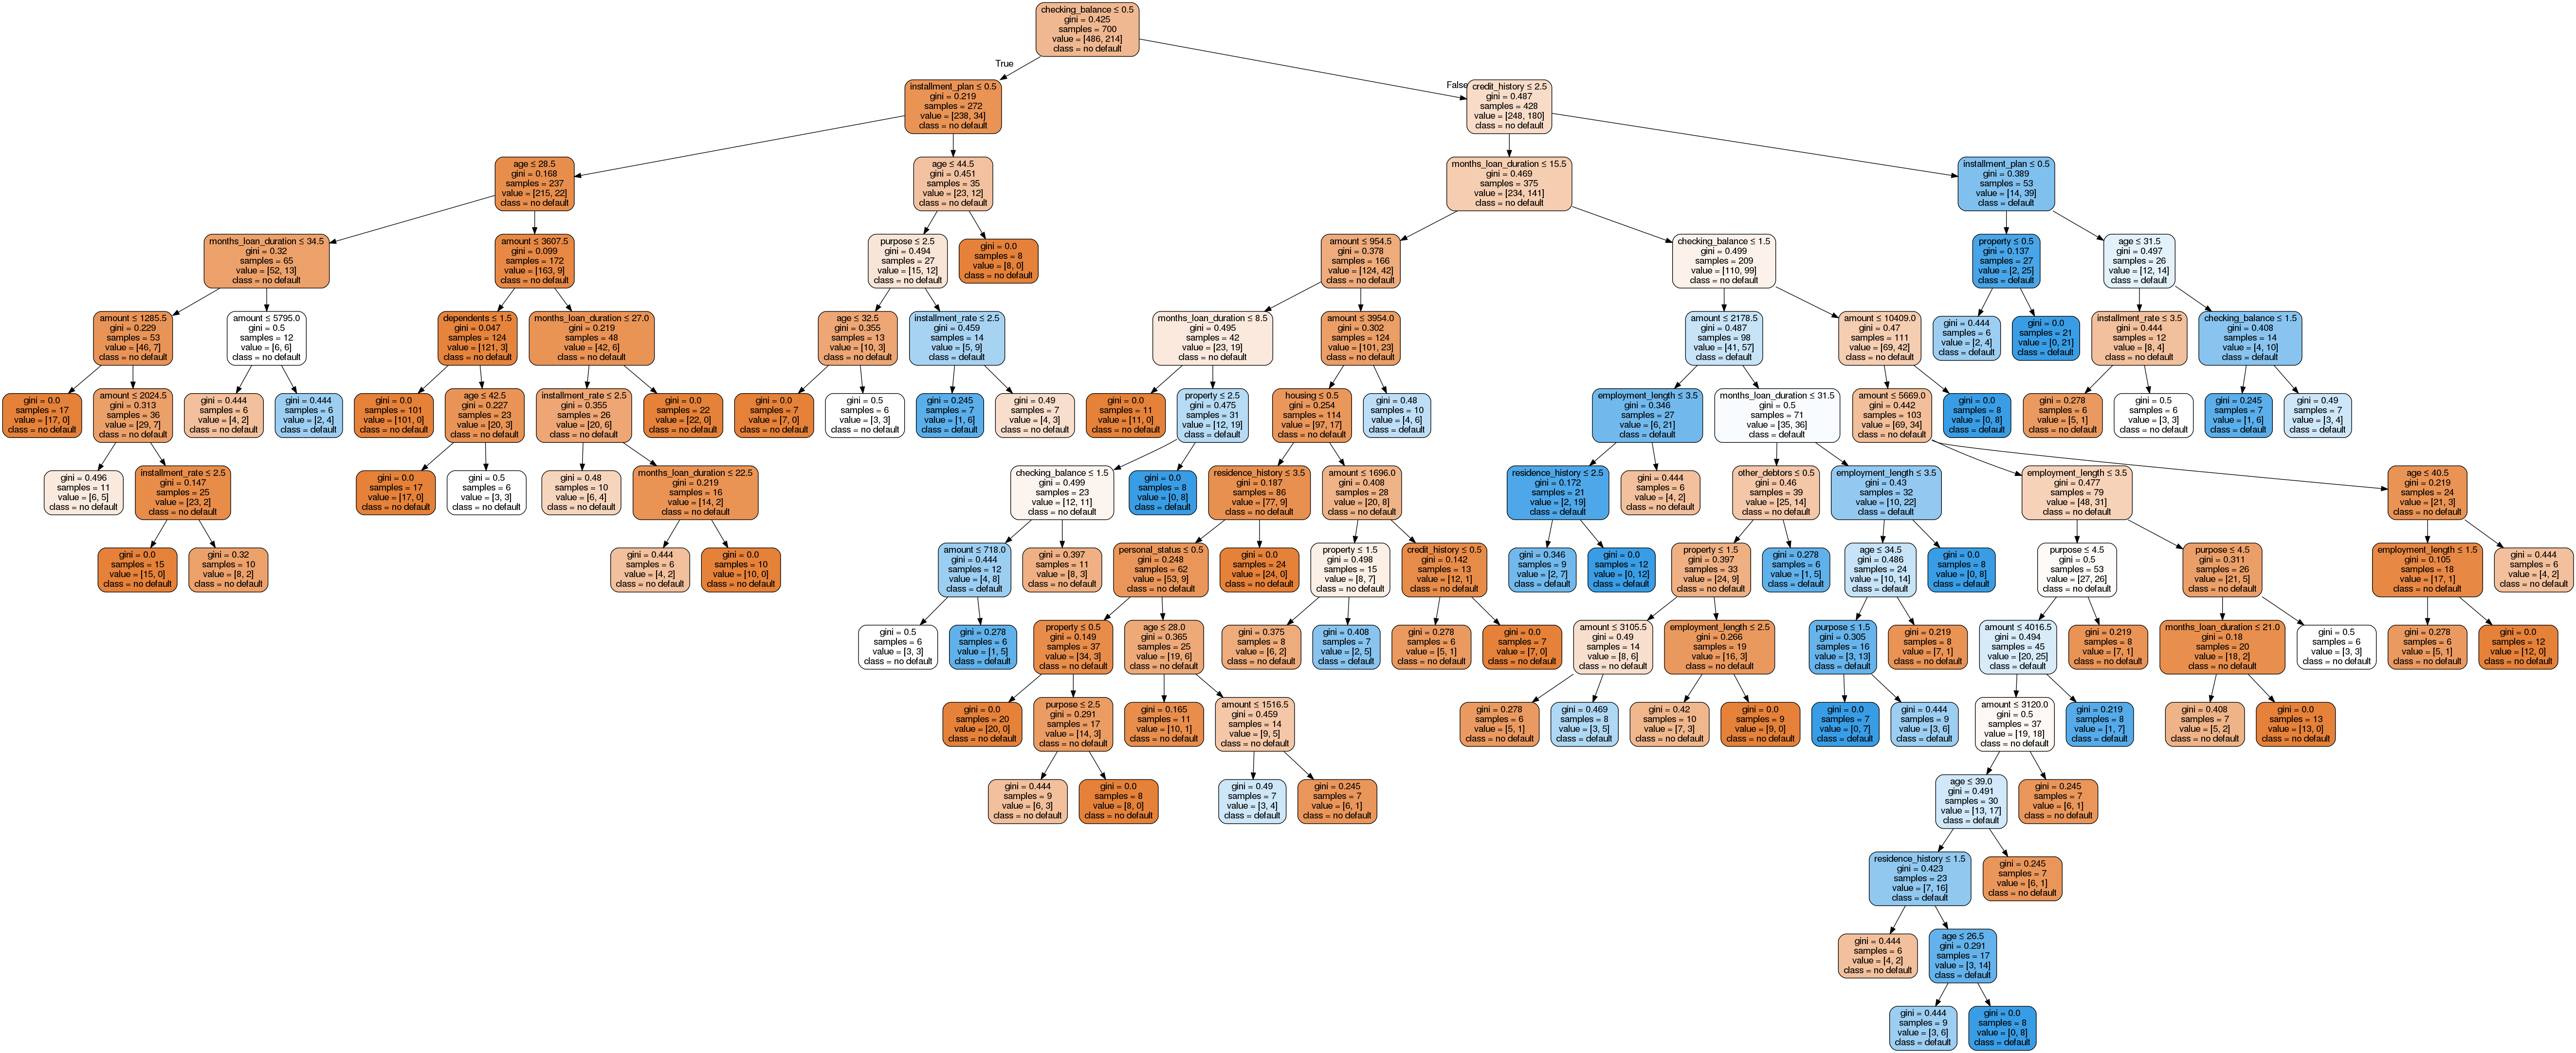

In [64]:
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot

dot_data = StringIO()
tree.export_graphviz(credit_model,out_file=dot_data,
                    feature_names=X_train.columns,
                    class_names=['no default', 'default'],
                    filled=True,rounded=True,
                    special_characters=True)
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

### 模型性能评估

为了将我们训练好的决策树模型应用于测试数据, 我们用 predict() 函数, 代码如下


In [70]:
credit_pred = credit_model.predict(X_test)

现在, 我们得到了决策树，模型在测试数据上预测结果, 通过将预测结果和真实结果进行对比可以评估模型性能, 可以使用 sklearn.metrics 包中的 classification_report() 和 confudion_matrix() 函数, 展示模型分类结果:

In [72]:
from sklearn import metrics
print(metrics.classification_report(y_test,credit_pred))
print(metrics.confusion_matrix(y_test,credit_pred))
print(metrics.accuracy_score(y_test,credit_pred))

             precision    recall  f1-score   support

          1       0.78      0.81      0.80       214
          2       0.49      0.44      0.46        86

avg / total       0.70      0.71      0.70       300

[[174  40]
 [ 48  38]]
0.706666666667


在 300 个贷款申请测试数据中, 模型的预测正确率为 70% 216 个未违约, 模型正确额预测了 81% , 84 个违约贷款中, 模型正确预测出了 44%, 西面我们看看能否改进模型的性能.

### 6 模型性能提升

在实际应用中, 模型的预测正确率不高, 很难将其应用到实时的信贷评审过程, 在本案例中, 如果一个模型, 将所有的贷款都预测为“未违约”,　此时模型的正确率为 72% , 而该模型是一个完全无用的模型, 上节中我们建立的模型, 正确率 70.7%, 但对于违约贷款的识别性能很差,　我们可以创建一个代价矩阵来定义模型,　犯不同错误时的代价,　假设我们认为一个贷款违约者给银行的损失是银行错过一个不违约的贷款者带来损失的４倍, 则违约代价的权重可以定义为:


In [74]:
class_weights = {1:1, 2:4}

credit_model_cost = DecisionTreeClassifier(max_depth=6,class_weight=class_weights)
credit_model_cost.fit(X_train,y_train)
credit_pred_cost = credit_model_cost.predict(X_test)


print(metrics.classification_report(y_test,credit_pred_cost))
print(metrics.confusion_matrix(y_test,credit_pred_cost))
print(metrics.accuracy_score(y_test,credit_pred_cost))

             precision    recall  f1-score   support

          1       0.87      0.47      0.61       214
          2       0.39      0.83      0.53        86

avg / total       0.73      0.57      0.59       300

[[101 113]
 [ 15  71]]
0.573333333333


可见模型整体的正确率下降为 58% 但是此时模型能将 86 个违约贷款中 72 个正确识别出来,　识别率为 84%.